<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/pytorch/Lab_Recurrent_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent models

In this lab, we will start working with the time series of ATM failures, in order to classify them. There are many other applications possible, such as clustering, regression, or even anomaly detection using autoencoders.

As always, let's first import the packages we will use and the data.

In [ ]:
# Install necessasary packages, if not done before
!pip install torchview
!pip install livelossplot

In [ ]:
import numpy as np
import PIL
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# For validation
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from torchview import draw_graph
import graphviz
from livelossplot import PlotLosses
graphviz.set_jupyter_format('png')
%matplotlib inline

# Import Pytorch lybraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import _LRScheduler

In [ ]:
!gdown https://drive.google.com/uc?id=1rQfs6djY8MjeMPqHxl0cHbqTCwLB3giD

In [ ]:
!unzip ATM.zip
!rm ATM.zip

Now we read the data. It comes from [this Github](https://github.com/victormvy/sigma-convkernels/blob/main/main.py) and [its related paper](https://arxiv.org/ftp/arxiv/papers/2305/2305.10059.pdf) that uses the logs from ATM to detect failures. The failures can be either because of foreign body, generic failure, jam, preventive maintenance, replacement of any part or bad usage. There are 38 measurements the ATM keeps track of over a day, divided into series of 144 points. So, our input is a matrix of size (38, 144) for every point, predicting if the machine will be functional one week into the future.

The following image, from the paper, describes the data.



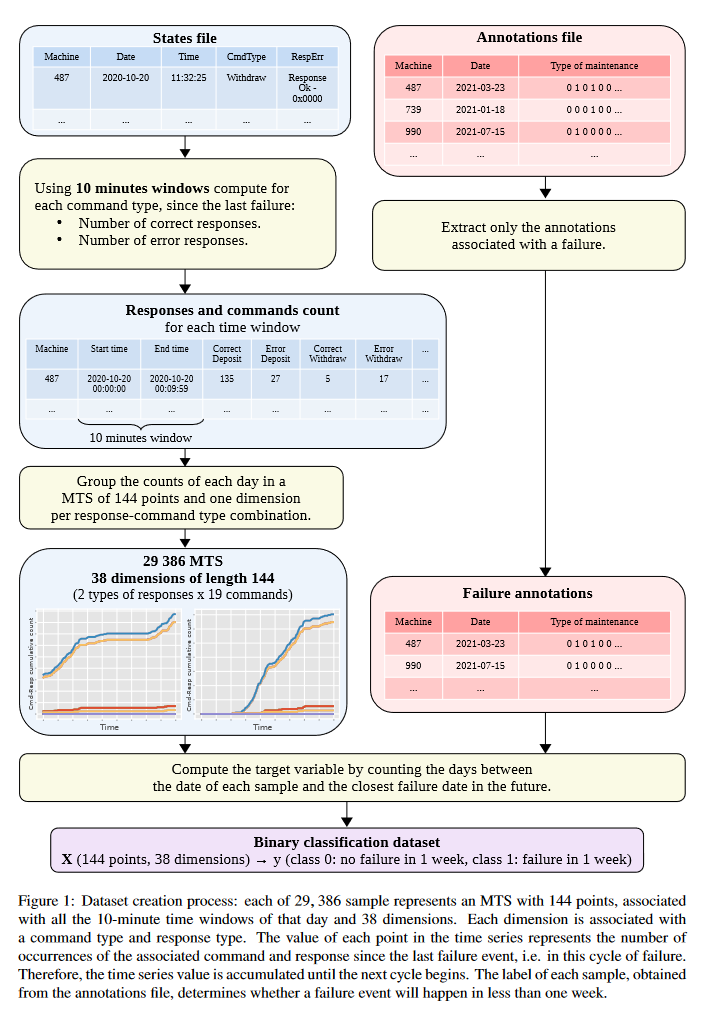

In [ ]:
# Read the data
data = np.load('sigma_pdm.npy', allow_pickle=True)

X = data[:, :-4, :]
y = data[:, -4:, -1]

del data

# Move to pandas
y_df = pd.DataFrame(y, columns = ['ID', 'Day', 'Type', 'Status'])

In [ ]:
# Create Pandas DataFrame for X
x_df = pd.DataFrame.from_records(X)
x_df

# Add the target
x_df['target'] = y_df['Status'].values

# Split the data
seed = 20240202
x_df['if_test'] = np.random.RandomState(seed=seed).binomial(1, 0.3, size=x_df.shape[0])
x_df.head()

In [ ]:
# Delete the original data
del X, y

Now we can plot one of the series for one of the cases.

In [ ]:
# For case 3, plot series 9.
plt.plot(x_df[2][8])
plt.show()

Now we are ready to start training models. Let's define torch's device so it runs the most efficient way possible.

In [ ]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The default device is set to {device}")

## Long-Short Term Memory (LSTM) Networks



First, we will train an LSTM. The LSTM is a fairly complex model, so VRAM will be a signficant constraint. Let's first set up the train and test dataset. We will normalize the data and One Hot Encode the labels using sklearn's [OneHotEncode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function. We will also set the class weights as we have done before.

In [ ]:
def scale_dataframe_sequences(x_df, test_var=None):
    # Prepare the scaler
    scaler = StandardScaler()

    # Split the data if test_var given
    if test_var is not None:
        x_train = x_df.loc[test_var==0, :]
        x_test = x_df.loc[test_var==1, :]
    else:
        x_train = x_df

    # Dictionary to store the scaled variables
    scaled_data = {}

    if test_var is not None:
        scaled_data_test = {}

    # Get the number of elements in a sequence
    seq_len = x_train.iloc[:, 0][0].shape[0]

    for column in x_df.columns:
        # Get data from the DataFrame and reshape to 2D array
        data = np.stack(x_train[column].values).reshape(-1, seq_len)

        # Scale the data
        scaled_data[column] = scaler.fit_transform(data).reshape(-1, 1, seq_len).tolist()

        # Apply to test set if needed
        if test_var is not None:
            data_test = np.stack(x_test[column].values).reshape(-1, seq_len)
            scaled_data_test[column] = scaler.transform(data_test).reshape(-1, 1, seq_len).tolist()

    # Create a new DataFrame with the scaled data
    scaled_df = pd.DataFrame(scaled_data)
    scaled_df = scaled_df.map(lambda x: np.array(x[0]))
    if test_var is not None:
        scaled_df_test = pd.DataFrame(scaled_data_test)
        scaled_df_test = scaled_df_test.map(lambda x: np.array(x[0]))
        return scaled_df, scaled_df_test
    else:
        return scaled_df, _


In [ ]:
# Create train and test datasets.
x_columns = x_df.columns[np.r_[0:37]]

# Normalize train and test
x_train, x_test = scale_dataframe_sequences(x_df.loc[:, x_columns], x_df['if_test'])

# Encode test set
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_train = enc.fit_transform(x_df.loc[x_df['if_test']==0, 'target'].values.reshape(-1, 1))[:, 1]
y_test = enc.transform(x_df.loc[x_df['if_test']==1, 'target'].values.reshape(-1, 1))[:, 1]

# Class weights
pos_weight = np.sum(1 - y_train) / np.sum(y_train)
pos_weight = torch.tensor(pos_weight,dtype=torch.float32).to(device)
pos_weight


Now we will create the LSTM. First, let's try to be naïve and see what happens if we simply try to train our LSTM using 128 cells and just passing the sequence. As we saw in the lectures, Google's LeNet showed that stacking parallel layers of convolution (so, not sequential models) seemed like a good idea. Would this idea work with LSTM?

Let's find out. For this, we will create a pytorch model and it's corresponding forward pass. We will use an LSTM to create an output embedding of the time series, and then pass that to a dense layer with droput that will classify the sequence. Finally, we will determine if the sequence is a suggesting a failure or not with a sigmoid output layer.


In [ ]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, classifier_dim, output_dim):
        super(LSTMClassifier, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Classifier network
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, classifier_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(classifier_dim, output_dim),
            #nn.Softmax(dim=1) # No need for softmax with logit loss.
       )

    # Forward method
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # Forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.classifier(out[:, -1, :])
        return out


Let's initatiate the model and see the diagram.

In [ ]:
# Initialize the model
n_vars = 37
atm_lstm_model = LSTMClassifier(n_vars, 128, 1, 256, 1).to(device)
print(atm_lstm_model)

In [ ]:
# Draw the model
model_graph = draw_graph(atm_lstm_model, input_size=(1, 128, n_vars),
                         device=device,
                         expand_nested=True)
model_graph.visual_graph


Now we are ready to train. Recurrent models are very tricky in terms of their training, and the gradients usually present a very erratic behaviour. It is a good idea to clip the gradients, that is, to lower the value of the gradient so it does not explode. There is a Torch utility called [```clip_grad_norm```](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html), which allows to set a maximum value against the mean for the gradient.

I would generally advice to use a value of around 1 to 2 if you are seeing erratic training behaviour.

We will use the series-oriented RMSprop as our optimizer, and implemente norm clipping in the training loop.

In [ ]:
# Set up optimizer and loss
learning_rate = 0.0001
optimizer = optim.RMSprop(atm_lstm_model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# Set global run parameters
best_vloss = 10000000

We also need to create the data loaders. These are pretty simple: Just read from the pandas dataset and split them into train and test. We can do that easily with the following code.

In [ ]:
def create_train_val_dataloaders(x_train_df, y_train, batch_size=64, val_size=0.33, seed=42):
    """
    Create DataLoader instances for training and validation datasets suited for LSTM models.

    Parameters:
    x_train_df (pandas.DataFrame): DataFrame where each cell is a sequence (1D array or list) of length seq_len.
    y_train (numpy.ndarray): The labels for training.
    batch_size (int): The batch size for both train and validation loaders.
    val_size (float): The fraction of the data to be used for validation.

    Returns:
    train_loader (DataLoader): DataLoader for the training set.
    val_loader (DataLoader): DataLoader for the validation set.
    """

    # Set the random seed for reproducibility
    torch.manual_seed(seed)

    # Convert the DataFrame of sequences into a correctly shaped 3D numpy array
    # sequences.shape should be (number of samples, seq_len, number of features per timestep)
    sequences = np.stack(x_train_df.apply(lambda s: np.stack(s.values).reshape(s.values[0].shape[0], -1), axis=1).values)

    # Check if y_train is a numpy array, if not convert it
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)

    if y_train.ndim == 1:
        y_train = y_train[:, None]  # Convert to 2D array if necessary

    # Convert to PyTorch tensors
    x_train_tensor = torch.from_numpy(sequences).float()
    y_train_tensor = torch.from_numpy(y_train).float()

    # Create the TensorDataset
    train_data = TensorDataset(x_train_tensor, y_train_tensor)

    # Split the dataset into train and validation sets
    total_samples = len(train_data)
    train_size = int((1 - val_size) * total_samples)
    val_size = total_samples - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

    # Create the dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [ ]:
# Create the data loaders
batch_size = 2048 # A100
train_loader, val_loader = create_train_val_dataloaders(x_train, y_train.reshape(-1,1),
                                                       batch_size=batch_size)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

# Softmax function for the output
softmax_func = np.vectorize(lambda x: 1/(1+np.exp(-1 * x)))

Now we are finally ready to train.

In [ ]:
# Set run parameters
n_epochs = 200
liveloss = PlotLosses()

# Train!
for epoch in range(n_epochs):
   # Run the epoch
  logs = {}

  # Run a train epoch, and then a validation epoch.
  for phase in ['train', 'validation']:
      if phase == 'train':
          atm_lstm_model.train()
      else:
          atm_lstm_model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i, data in enumerate(dataloaders[phase]):
          inputs, labels = data
          # print(labels)
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = atm_lstm_model(inputs).to(device)
          loss = loss_fn(outputs, labels)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()

              # Clip the gradient norm
              nn.utils.clip_grad_norm_(atm_lstm_model.parameters(), 2)

              # Backpropagate
              optimizer.step()

          preds = softmax_func(outputs.detach().cpu().numpy())
          preds = np.round(preds)
          running_loss += loss.detach() * inputs.size(0)
          running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

          if i % 10 == 9:
            batch_loss = running_loss / (10 * (i+1))
            print(f'{phase} batch {i+1} loss: {batch_loss:.3f}')
            tb_x = epoch * len(dataloaders[phase]) + i + 1

          # Delete the used VRAM
          torch.cuda.empty_cache()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)

      prefix = ''
      if phase == 'validation':
          prefix = 'val_'

          # Track best performance, and save the model's state
          if epoch_loss < best_vloss:
              best_vloss = epoch_loss
              model_path = 'best_model.ph'
              print(f'New best model found. Saving it as {model_path}')
              torch.save(atm_lstm_model.state_dict(), model_path)

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

  liveloss.update(logs)
  liveloss.send()

Training is progressing! Let's apply it to the test set and see what we get. You may also want to keep training, as the model is still learning after 200 epochs.

In [ ]:
def create_test_dataloader(x_test_df, y_test=None, batch_size=64, seed=42):
    """
    Create DataLoader instance for the test dataset.

    Parameters:
    x_test_df (pandas.DataFrame): DataFrame where each cell is a sequence (1D array or list) of length seq_len.
    y_test (numpy.ndarray, optional): The labels for testing. Pass None if there are no labels.
    batch_size (int): The batch size for the test loader.

    Returns:
    test_loader (DataLoader): DataLoader for the test set.
    """

    # Set the random seed for reproducibility
    torch.manual_seed(seed)

    # Convert the DataFrame of sequences into a correctly shaped 3D numpy array
    # sequences.shape should be (number of samples, seq_len, number of features per timestep)
    sequences = np.stack(x_test_df.apply(lambda s: np.stack(s.values).reshape(s.values[0].shape[0], -1), axis=1).values)

    # Convert to PyTorch tensors
    x_test_tensor = torch.from_numpy(sequences).float()

    # Create a TensorDataset from the input data
    if y_test is not None:
        # Check if y_test is a numpy array, if not convert it
        if not isinstance(y_test, np.ndarray):
            y_test = np.array(y_test)

        # Convert labels to a PyTorch tensor
        y_test_tensor = torch.from_numpy(y_test).float()

        # Assert that the number of samples matches
        assert len(x_test_tensor) == len(y_test_tensor), "The number of input samples and labels must be the same."
        test_data = TensorDataset(x_test_tensor, y_test_tensor)
    else:
        test_data = TensorDataset(x_test_tensor)

    # Create the DataLoader for the test set
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return test_loader

In [ ]:
test_loader = create_test_dataloader(x_test, y_test.reshape(-1,1))

In [ ]:
atm_lstm_model.load_state_dict(torch.load('best_model.ph'))

In [ ]:
# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    atm_lstm_model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = atm_lstm_model(inputs)
        test_probs = np.append(test_probs, outputs.cpu().numpy())
        outputs = outputs.to(device)
        loss = loss_fn(outputs, labels)

        preds = softmax_func(outputs.cpu().numpy())
        preds = np.round(preds)
        test_predictions = np.append(test_predictions, preds)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

test_loss = running_loss / len(test_loader.dataset)
test_acc = running_corrects / len(test_loader.dataset)

print(f'The test set accuracy is {test_acc*100:.2f}%')
print(f'The test set loss is {test_loss:.3f}')

In [ ]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = test_labels,
                    y_pred = test_predictions)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_labels,
                             y_score = test_probs),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="ATM Failures, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The model is not learning much with this architecture. Let's see if we can improve upon this.

## LSTM with multiple layers

To improve training, we can try to  chain LSTMs. This can help as you won't need to add just one very large (thus intractable) LSTM and instead can train two smaller ones. This is easily done in pytorch simply by setting the ```layer_dim``` parameter to a higher number. Let's try to stack two LSTMs and see the performance.

In [ ]:
# Initialize the model
n_vars = 37
atm_lstm_model = LSTMClassifier(n_vars, 256, 2, 256, 1).to(device)
print(atm_lstm_model)

# Draw the model
model_graph = draw_graph(atm_lstm_model, input_size=(1, 256, n_vars),
                         device=device,
                         expand_nested=True)
model_graph.visual_graph


As we can see, this model now passes a much more reduced number of features to the LSTM layer, thus allowing for a reduced complexity. Of course, this will only be as good as the features are, so you'll need to experiment to get this right.

Let's train the model.

We will be very aggressive with the norm clipping now. You can identify the need for this if the losses are very unstable. Experiment with this value for your own applications! We'll also use Adam as our optimizer.

In [ ]:
# Set up optimizer and loss
learning_rate = 0.001
optimizer = optim.RMSprop(atm_lstm_model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# Set global run parameters
best_vloss = 10000000

In [ ]:
# Create the data loaders
train_loader, val_loader = create_train_val_dataloaders(x_train, y_train.reshape(-1,1),
                                                       batch_size=batch_size)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

In [ ]:
# Set run parameters
n_epochs = 300
liveloss = PlotLosses()


# Train!
for epoch in range(n_epochs):
   # Run the epoch
  logs = {}

  # Run a train epoch, and then a validation epoch.
  for phase in ['train', 'validation']:
      if phase == 'train':
          atm_lstm_model.train()
      else:
          atm_lstm_model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i, data in enumerate(dataloaders[phase]):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = atm_lstm_model(inputs).to(device)
          loss = loss_fn(outputs, labels)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()
              # Clip the gradient norm
              nn.utils.clip_grad_norm_(atm_lstm_model.parameters(), 0.1)
              # Backpropagate
              optimizer.step()

          preds = softmax_func(outputs.detach().cpu().numpy())
          preds = np.round(preds)
          running_loss += loss.detach() * inputs.size(0)
          running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

          if i % 10 == 9:
            batch_loss = running_loss / (10 * (i+1))
            print(f'{phase} batch {i+1} loss: {batch_loss:.3f}')
            tb_x = epoch * len(dataloaders[phase]) + i + 1

          # Delete the used VRAM
          torch.cuda.empty_cache()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)

      prefix = ''
      if phase == 'validation':
          prefix = 'val_'

          # Track best performance, and save the model's state
          if epoch_loss < best_vloss:
              best_vloss = epoch_loss
              model_path = 'best_model.ph'
              print(f'New best model found. Saving it as {model_path}')
              torch.save(atm_lstm_model.state_dict(), model_path)

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

  liveloss.update(logs)
  liveloss.send()

That's better! We can see the LSTM now reaches a much better loss. Remember, this was done without **any** data cleaning, just standardization! Also of note is how long it took the optimizer to find a proper direction of descent. It pays to have a good patience!

We can see that learning stalls around 100 epochs. This is why we use callbacks, we can now simply recover the optimal model and train again with a lower rate if needed.

Finally, I did not **acid test** this model. It is very easy to add redundant layers to the model or even redundant series, as our model has 37 series to get patterns from. Try playing around with the model and continue training. It should not be hard to improve these results further.

Let's see the performance now over the test set. We start by loading the best model.

In [ ]:
atm_lstm_model.load_state_dict(torch.load('best_model.ph'))

In [ ]:
# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    atm_lstm_model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = atm_lstm_model(inputs)
        test_probs = np.append(test_probs, outputs.cpu().numpy())
        outputs = outputs.to(device)
        loss = loss_fn(outputs, labels)

        preds = softmax_func(outputs.cpu().numpy())
        preds = np.round(preds)
        test_predictions = np.append(test_predictions, preds)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

test_loss = running_loss / len(test_loader.dataset)
test_acc = running_corrects / len(test_loader.dataset)

print(f'The test set accuracy is {test_acc*100:.2f}%')
print(f'The test set loss is {test_loss:.3f}')

In [ ]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = test_labels,
                    y_pred = test_predictions)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

This is a pretty good model! The ROC curve will give us a better view of what is happening.

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_labels,
                             y_score = test_probs),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="ATM Failures - LSTM, auc="+str(auc))
plt.legend(loc=4)
plt.show()

We are obtaining an amazing AUC! Given how unbalanced our model is though, the AUC may be misleading. An alternative would be to calculate the AUPRC and use that. In any case, our model is looking very good!

## GRU

Now we will train a GRU. In theory, a GRU will be able to reach the same results as the LSTM but using less parameters.

GRUs are more efficient, so you can either use the same size that will run faster, or increase the size to try to learn more. Let's do the former.

In [ ]:
# Define the LSTM model
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, classifier_dim, output_dim):
        super(GRUClassifier, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your GRU
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Classifier network
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, classifier_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(classifier_dim, output_dim),
            #nn.Softmax(dim=1) # No need for softmax with logit loss.
       )

    # Forward method
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # Forward pass
        out, hn = self.gru(x, h0)
        out = self.classifier(out[:, -1, :])
        return out


In [ ]:
# Initialize the model
n_vars = 37
atm_gru_model = GRUClassifier(n_vars, 256, 2, 256, 1).to(device)
print(atm_gru_model)

# Draw the model
model_graph = draw_graph(atm_gru_model, input_size=(1, 256, n_vars),
                         device=device,
                         expand_nested=True)
model_graph.visual_graph


Perfect! Let's train the model now. The process is the same as before.

In [ ]:
# Set up optimizer and loss
learning_rate = 0.001
optimizer = optim.RMSprop(atm_gru_model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# Set global run parameters
best_vloss = 10000000

In [ ]:
# Create the data loaders
train_loader, val_loader = create_train_val_dataloaders(x_train, y_train.reshape(-1,1),
                                                       batch_size=batch_size)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

In [ ]:
# Set run parameters
n_epochs = 200
liveloss = PlotLosses()

# Train!
for epoch in range(n_epochs):
   # Run the epoch
  logs = {}

  # Run a train epoch, and then a validation epoch.
  for phase in ['train', 'validation']:
      if phase == 'train':
          atm_gru_model.train()
      else:
          atm_gru_model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i, data in enumerate(dataloaders[phase]):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = atm_gru_model(inputs).to(device)
          loss = loss_fn(outputs, labels)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()
              # Clip the gradient norm
              nn.utils.clip_grad_norm_(atm_gru_model.parameters(), 0.1)
              # Backpropagate
              optimizer.step()

          preds = softmax_func(outputs.detach().cpu().numpy())
          preds = np.round(preds)
          running_loss += loss.detach() * inputs.size(0)
          running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

          if i % 10 == 9:
            batch_loss = running_loss / (10 * (i+1))
            print(f'{phase} batch {i+1} loss: {batch_loss:.3f}')
            tb_x = epoch * len(dataloaders[phase]) + i + 1

          # Delete the used VRAM
          torch.cuda.empty_cache()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)

      prefix = ''
      if phase == 'validation':
          prefix = 'val_'

          # Track best performance, and save the model's state
          if epoch_loss < best_vloss:
              best_vloss = epoch_loss
              model_path = 'best_gru_model.ph'
              print(f'New best model found. Saving it as {model_path}')
              torch.save(atm_gru_model.state_dict(), model_path)

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

  liveloss.update(logs)
  liveloss.send()

In [ ]:
atm_gru_model.load_state_dict(torch.load('best_gru_model.ph'))

In [ ]:
# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    atm_gru_model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = atm_gru_model(inputs)
        test_probs = np.append(test_probs, outputs.cpu().numpy())
        outputs = outputs.to(device)
        loss = loss_fn(outputs, labels)

        preds = softmax_func(outputs.cpu().numpy())
        preds = np.round(preds)
        test_predictions = np.append(test_predictions, preds)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

test_loss = running_loss / len(test_loader.dataset)
test_acc = running_corrects / len(test_loader.dataset)

print(f'The test set accuracy is {test_acc*100:.2f}%')
print(f'The test set loss is {test_loss:.3f}')

In [ ]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = test_labels,
                    y_pred = test_predictions)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_labels,
                             y_score = test_probs),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="ATM Failures - GRU, auc="+str(auc))
plt.legend(loc=4)
plt.show()

We got an even better model! And it took only 200 epochs to get here. Try to see if you can reach better ones! Let's load the optimal parameters and measure performance.

Can you do better? Experiment with the parameters, set a [Learning Rate Scheduler](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling) to train more slowly after epoch 200. Experiment! I got these results playing around with the parameters in a few hours. See what you can get!

In any case, sequence-based models have evolved greatly beyond LSTM and GRU. In particular, one specific transform has been shown to be a significant advancement over these models: The Transformer.